In [1]:
# -*- coding: utf-8 -*-
"""render_demo.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/16k9N-US0ZBpVHH8DvjwWhlS9zW0T_Eyb
"""

'render_demo.ipynb\nAutomatically generated by Colaboratory.\nOriginal file is located at\n    https://colab.research.google.com/drive/16k9N-US0ZBpVHH8DvjwWhlS9zW0T_Eyb\n'

In [2]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [3]:
import numpy as np
import imageio
import pprint
import matplotlib.pyplot as plt
from IPython.display import display
import run_nerf
from load_llff import load_llff_data

asedir = './logs'<br>
xpname = 'fern_test'

In [4]:
basedir = './logs'
expname = 'kettleimage_test'

In [5]:
config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())
parser = run_nerf.config_parser()

Args:
expname = cagec_test
basedir = ./logs
datadir = ./data/nerf_llff_data/cagec
dataset_type = llff

factor = 8
llffhold = 8

N_rand = 512
N_samples = 32
N_importance = 32

use_viewdirs = True
raw_noise_std = 1e0




In [6]:
args = parser.parse_args('--config {} --ft_path {}'.format(config, os.path.join(basedir, expname, 'model_460000.npy')))
print('loaded args')

loaded args


In [7]:
images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor, 
                                                          recenter=True, bd_factor=.75, 
                                                          spherify=args.spherify)
H, W, focal = poses[0,:3,-1].astype(np.float32)

Loaded image data (378, 504, 3, 25) [378.         504.         379.45908739]
Loaded ./data/nerf_llff_data/cagec 2.0948519641710335 69.59057510258867
recentered (3, 5)
[[ 1.00000000e+00 -3.28051497e-09  2.73603593e-08 -2.19345097e-07]
 [ 3.28051475e-09  1.00000000e+00  8.39465564e-09  2.98023228e-09]
 [-2.73603575e-08 -8.39465564e-09  1.00000000e+00  1.07288365e-08]]
Data:
(25, 3, 5) (25, 378, 504, 3) (25, 2)
HOLDOUT view is 14


In [8]:
H = int(H)
W = int(W)
hwf = [H, W, focal]

In [9]:
images = images.astype(np.float32)
poses = poses.astype(np.float32)

In [10]:
if args.no_ndc:
    near = tf.reduce_min(bds) * .9
    far = tf.reduce_max(bds) * 1.
else:
    near = 0.
    far = 1.

Create nerf model

In [11]:
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
Found ckpts ['./logs\\cagec_test\\model_460000.npy']
Reloading from ./logs\cagec_test\model_460000.npy
Resetting step to 460001
Reloading fine from ./logs\cagec_test\model_fine_460000.npy


In [12]:
bds_dict = {
    'near' : tf.cast(near, tf.float32),
    'far' : tf.cast(far, tf.float32),
}
render_kwargs_test.update(bds_dict)

In [13]:
print('Render kwargs:')
pprint.pprint(render_kwargs_test)

Render kwargs:
{'N_importance': 32,
 'N_samples': 32,
 'far': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'near': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'network_fine': <keras.engine.functional.Functional object at 0x000001B7800E4D00>,
 'network_fn': <keras.engine.functional.Functional object at 0x000001B7E5105780>,
 'network_query_fn': <function create_nerf.<locals>.network_query_fn at 0x000001B7E50BA7A0>,
 'perturb': False,
 'raw_noise_std': 0.0,
 'use_viewdirs': True,
 'white_bkgd': False}


In [14]:
down = 4
render_kwargs_fast = {k : render_kwargs_test[k] for k in render_kwargs_test}
render_kwargs_fast['N_importance'] = 0

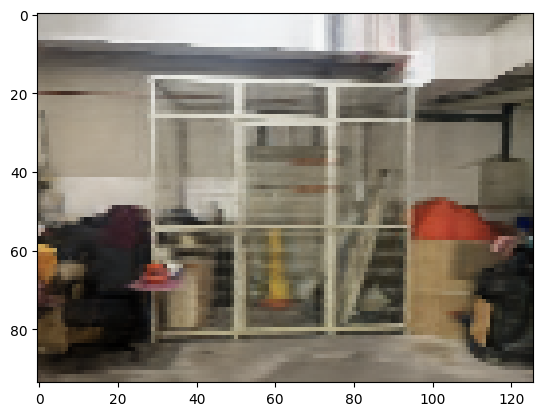

In [15]:
c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

In [16]:
'''
down = 1 # trade off resolution+aliasing for render speed to make this video faster
frames = []
for i, c2w in enumerate(render_poses):
    if i%8==0: print(i)
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w[:3,:4], **render_kwargs_fast)
    frame = (255*np.clip(test[0],0,1)).astype(np.uint8)
    frames.append(frame)
    
print('done, saving')
f = 'logs/kettleimage_test/video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=8)
'''

"\ndown = 1 # trade off resolution+aliasing for render speed to make this video faster\nframes = []\nfor i, c2w in enumerate(render_poses):\n    if i%8==0: print(i)\n    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w[:3,:4], **render_kwargs_fast)\n    frame = (255*np.clip(test[0],0,1)).astype(np.uint8)\n    frames.append(frame)\n    \nprint('done, saving')\nf = 'logs/cagec_test/video.mp4'\nimageio.mimwrite(f, frames, fps=30, quality=8)\n"

In [17]:
'''
from IPython.display import Video
Video(f, height=320)
'''

'\nfrom IPython.display import Video\nVideo(f, height=320)\n'

Commented out IPython magic to ensure Python compatibility.<br>
%matplotlib inline

In [18]:
from ipywidgets import interactive, widgets
import matplotlib.pyplot as plt
import numpy as np

In [19]:
def f(x, y, z):
    
    c2w = tf.convert_to_tensor([
        [1,0,0,x],
        [0,1,0,y],
        [0,0,1,z],
        [0,0,0,1],
    ], dtype=tf.float32)
    
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
    img = np.clip(test[0],0,1)
    
    plt.figure("Interactive", figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

In [20]:
def f2(theta, x, y, z):
    
    c2w = tf.convert_to_tensor([
        [np.cos(theta), -np.sin(theta), 0, x],
        [np.sin(theta), np.cos(theta), 0 , y],
        [0, 0, 1, z],
        [0, 0, 0, 1]
    ], dtype = tf.float32)
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
    img = np.clip(test[0],0,1)
    
    plt.figure("Interactive", figsize=(20,6))
    plt.imshow(img)
    plt.show()

In [35]:
down = 1
def move_cam(roll, pitch, yaw, x, y, z):

    c2w = tf.convert_to_tensor([
        [0,0,0,x],
        [0,0,0,y],
        [0,0,0,z],
        [0,0,0,1],
    ], dtype=tf.float32)
    
    Rx = tf.convert_to_tensor([
        [1,0,0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)],
    ], dtype = tf.float32)

    
    Ry = tf.convert_to_tensor([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)],
    ], dtype = tf.float32)

    
    Rz = tf.convert_to_tensor([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1],
    ], dtype = tf.float32)

    
    R = np.matmul(Ry, Rx)
    R = np.matmul(R, Rz)
    
    Rtemp = np.zeros((4,4))
    for i in range(0,3):
        Rtemp[i, :3] = R[i]
    
    R = Rtemp
    
    c2w = c2w + R

    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_test)
    img = np.clip(test[0],0,1)
    
    plt.figure("Interactive", figsize=(20,6))
    plt.imshow(img)
    plt.show()
    print(f"finished rendering roll = {roll}, pitch = {pitch}, yaw = {yaw}, x = {x}, y = {y}, z = {z}")

In [36]:
sldr = lambda : widgets.FloatSlider(
    value=0.,
    min=-10.,
    max=10.,
    step=.01,
)

In [37]:
rotation_sldr = lambda : widgets.FloatSlider(
    value = 0.,
    min = -1.,
    max = 1.,
    step = 0.05,
)

In [38]:
names = ['roll','pitch','yaw','x', 'y', 'z']
#interactive_plot = interactive(move_cam, **{n : sldr() for n in names})

interactive_plot = interactive(move_cam, roll = rotation_sldr(),
                               pitch = rotation_sldr(),
                               yaw = rotation_sldr(),
                              x = sldr(),
                              y = sldr(),
                              z = sldr())

interactive_plot

interactive(children=(FloatSlider(value=0.0, description='roll', max=1.0, min=-1.0, step=0.05), FloatSlider(va…